In [1]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from astropy.io import fits
from astropy.table import Table

In [2]:
# Cargar los datos a partir de los archivos FITS
path_datos = "/home/21953404Victor/SDC3/SDC3GIT/data_actualizada/"
path = path_datos + "ZW3.msw_image.fits"
hdul = fits.open(path)

Transformación del catálogo de fuentes completo (almacenado)

In [3]:

# ruta_carpeta_catalogos = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 1/resultados"
# ruta_carpeta_resultados = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 1/labels"
# archivos = os.listdir(ruta_carpeta_catalogos)

# # Función para crear un archivo de anotación para cada catálogo
# def crear_anotaciones(path_cat, path_anotacion):
#     cat = Table.read(path_cat, format="ascii")
#     clase = "fuente"

#     with open(path_anotacion, "w") as f:
#         for row in cat:
#             x = row["X_IMAGE"]
#             y = row["Y_IMAGE"]
#             f.write(f"{x} {y} {clase}\n")

# # Procesar todos los archivos de catálogo en la carpeta
# for archivo in archivos:
#     # Extraer el número de kHz del nombre del archivo
#     num_khz = re.search(r"(\d+)kHz", archivo).group(1)

#     # Crear un nombre para el archivo de anotación correspondiente
#     anotacion_nombre = f"catalogo_completo_1_{num_khz}kHz.txt"

#     # Crear el archivo de anotación para el catálogo actual
#     crear_anotaciones(
#         os.path.join(ruta_carpeta_catalogos, archivo),
#         os.path.join(ruta_carpeta_resultados, anotacion_nombre)
#    )


In [4]:
# ruta_carpeta_resultados = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 1/labels"
# archivos = os.listdir(ruta_carpeta_resultados)

# def clamp(value, min_value, max_value):
#     return max(min(value, max_value), min_value)

# def procesar_archivo(path_txt):
#     with open(path_txt, "r") as f:
#         lines = f.readlines()

#     label = np.zeros((2048, 2048), dtype=int)

#     for line in lines:
#         x, y, _ = line.split()
#         x, y = int(float(x)), int(float(y))

#         for i in range(-4, 4):
#             for j in range(-4, 4):
#                 x_coord = clamp(x + i, 0, 2047)
#                 y_coord = clamp(y + j, 0, 2047)
#                 label[y_coord, x_coord] = 1

#     return label

# # Crear una lista para guardar los datos procesados
# target=[]

# # Procesar todos los archivos de texto en la carpeta de resultados
# for archivo in archivos:
#     path_txt = os.path.join(ruta_carpeta_resultados, archivo)
#     label = procesar_archivo(path_txt)
#     target.append(label)


In [5]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# Cargar los datos y dividirlos en conjuntos de entrenamiento y validación
num_samples = len(hdul[0].data) # Cargar todos los datos en lugar de una muestra de todas las imágenes
all_data = hdul[0].data
indices = sorted(np.random.choice(all_data.shape[0], num_samples, replace=False))
data = all_data[indices]

input_data = np.array(data).astype("float32") / 255.0 # Normalizar los datos de entrada (en formato de 8 bits implica que cad píxel tenga un valor de 0 a 255)
input_data = input_data.reshape((data.shape[0], 1, data.shape[1], data.shape[2]))

del all_data
del hdul
del data

# En lugar de repetir el label ahora se carga la lista de labels. El resto del proceso es igual
output_data = np.array(fits.open('/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 1/fit/LABEL_COMPLETO_V1.fit')[0].data).astype("float32")#[:, np.newaxis, :, :] # Agregar una dimensión para mantener el formato de los datos de entrada de la red neuronal

x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

del input_data
del output_data

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).unsqueeze(1)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val).unsqueeze(1)



train_data = TensorDataset(x_train, y_train)
val_data = TensorDataset(x_val, y_val)

tam_lote=2

train_loader = DataLoader(train_data, batch_size=tam_lote, shuffle=True)
val_loader = DataLoader(val_data, batch_size=tam_lote, shuffle=False)

In [7]:
# Crear la CNN
encoder = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU()
)

decoder = nn.Sequential(
    nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.ConvTranspose2d(32, 1, 3, padding=1),
    nn.Sigmoid()
)

encoder = encoder.to(device)
decoder = decoder.to(device)

# Función de pérdida y optimizador
criterion = nn.BCELoss()

# Unimos los parámetros de encoder y decoder en un solo optimizador (convolución y deconvolución)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
#optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0005) 

Epoch 1/100, Pérdida del train: 0.1918199269307984, Pérdida del test: 97.12006478781228
Epoch 2/100, Pérdida del train: 0.04840013221320179, Pérdida del test: 49.84033668434227
Epoch 3/100, Pérdida del train: 0.04338367548253801, Pérdida del test: 0.5287311588014875
Epoch 4/100, Pérdida del train: 0.04156988203111622, Pérdida del test: 85.49821103274168
Epoch 5/100, Pérdida del train: 0.040095047047361734, Pérdida del test: 97.0171890258789
Epoch 6/100, Pérdida del train: 0.039473427951128945, Pérdida del test: 68.45954945323231
Epoch 7/100, Pérdida del train: 0.03879069703010221, Pérdida del test: 97.1285149710519
Epoch 8/100, Pérdida del train: 0.03833251401988996, Pérdida del test: 97.16189826713814
Epoch 9/100, Pérdida del train: 0.03777775010611448, Pérdida del test: 65.05249442635002
Epoch 10/100, Pérdida del train: 0.037707278753320375, Pérdida del test: 97.13993936056619
Epoch 11/100, Pérdida del train: 0.03704495010897517, Pérdida del test: 0.2583835373867999
Epoch 12/100, Pér

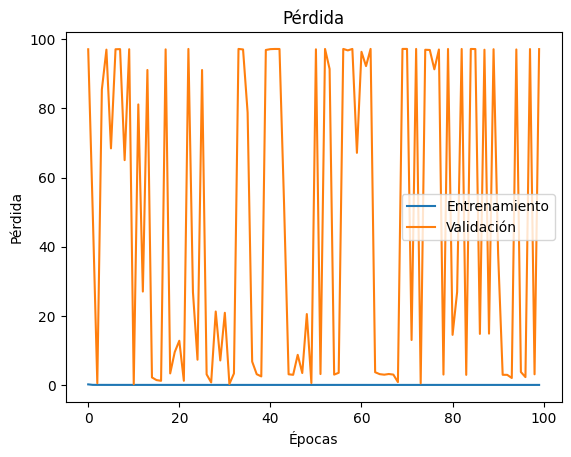

In [8]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        enc_output = encoder(images)
        dec_output = decoder(enc_output)


        # Convertir las etiquetas a float
        labels_float = labels.float()

        loss = criterion(dec_output, labels_float)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    train_losses.append(train_loss / len(train_loader))
    
    encoder.eval()
    decoder.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            enc_output = encoder(images)
            dec_output = decoder(enc_output)
            dec_output = torch.squeeze(dec_output, dim=1) 
            
            # Convertir las etiquetas a float
            labels_float = labels.float()
            labels_float = torch.squeeze(labels_float, dim=1)
            
            loss = criterion(dec_output, labels_float)
            
            val_loss += loss.item()

    
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Pérdida del train: {train_losses[-1]}, Pérdida del test: {val_losses[-1]}")

# Gráfico de pérdida
plt.plot(train_losses, label="Entrenamiento")
plt.plot(val_losses, label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdida")
plt.legend()
plt.show()

In [9]:
torch.save(decoder.state_dict(), 'decoder_gpu_cat_completo_pytorch.pt')
torch.save(encoder.state_dict(), 'encoder_gpu_cat_completo_pytorch.pt')